In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 52.3 MB/s eta 0:00:00


In [4]:
import rasterio
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

In [5]:
import os
import rasterio

def load_images_from_folder(root_folder):
    images = []
    labels = []
    for class_folder in os.listdir(root_folder):
        class_folder_path = os.path.join(root_folder, class_folder)
        if os.path.isdir(class_folder_path):
            for filename in os.listdir(class_folder_path):
                if filename.endswith('.tif'):
                    img_path = os.path.join(class_folder_path, filename)
                    try:
                        img = rasterio.open(img_path)
                        images.append(img.read().transpose((1, 2, 0)))
                        labels.append(class_folder)  # The label is the name of the parent directory
                    except RasterioIOError:
                        print(f'Failed to load {img_path}. Skipping.')
    return np.array(images), np.array(labels)

In [8]:
data, labels = load_images_from_folder('/content/drive/MyDrive/train')

In [9]:
data = data.astype("float32") / 65535
data = data.reshape(data.shape[0], 64, 64, 13)

In [10]:
shap_train, shap_test,_,_= train_test_split(data, labels, test_size=0.01, random_state=69, stratify=labels)

In [11]:
print("Shape of x_train:", shap_train.shape)
print("Shape of x_test:", shap_test.shape)

Shape of x_train: (974, 64, 64, 13)
Shape of x_test: (10, 64, 64, 13)


In [12]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/13_band_full.h5')

In [13]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.5 MB/s eta 0:00:00


In [14]:
import shap

In [15]:
background = shap_train[np.random.choice(shap_train.shape[0], 500, replace=False)]
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(shap_test[0:10])

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [16]:
class_names = ['AnnualCrop','Forest', 'HerbaceousVegetation',
                 'Highway', 'Industrial', 'Pasture',
                 'PermanentCrop', 'Residential', 'River',
                 'SeaLake']

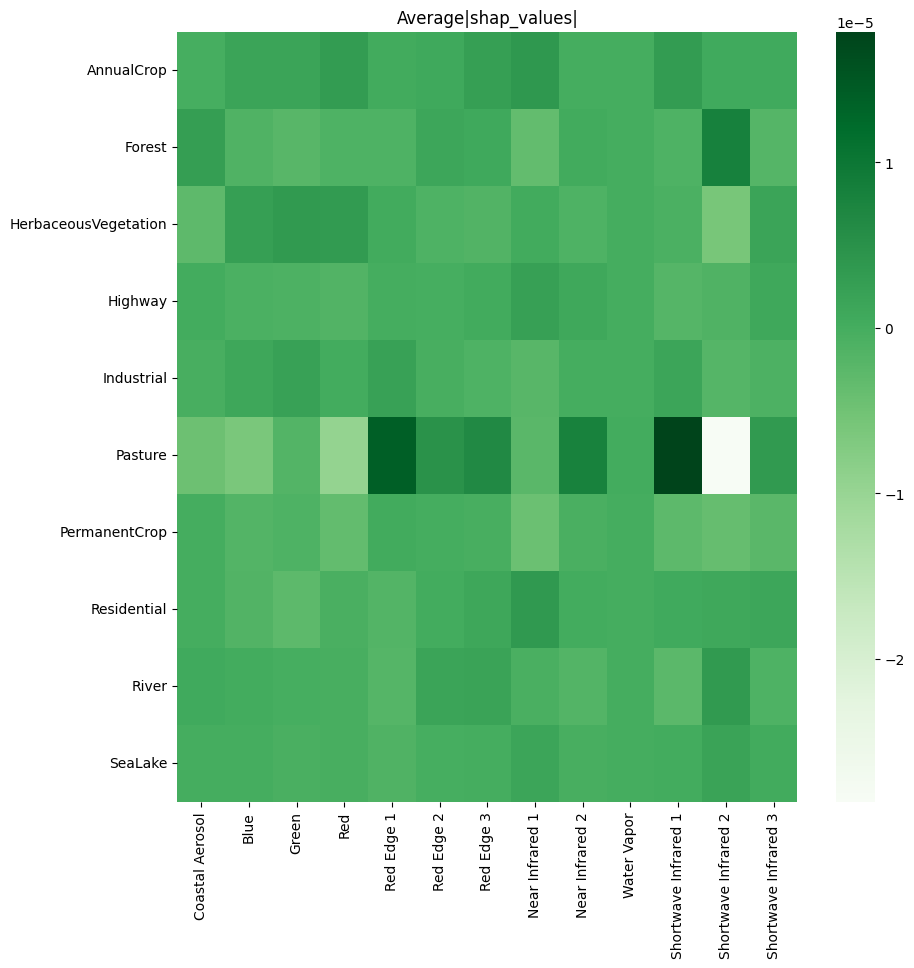

In [17]:
avg_shap_values = shap_values.mean(axis=(0, 1, 2))
import pandas as pd
# Convert the 2D array to a DataFrame for easier plotting
df = pd.DataFrame(avg_shap_values.T, columns=["Coastal Aerosol", "Blue", "Green", "Red", "Red Edge 1", "Red Edge 2", "Red Edge 3", "Near Infrared 1", "Near Infrared 2", "Water Vapor", "Shortwave Infrared 1", "Shortwave Infrared 2", "Shortwave Infrared 3"], index=class_names)

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df,cmap='Greens')
plt.title('Average|shap_values|')
plt.show()